Fashion MNIST Neural Net example using PyTorch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [2]:
# Download training data from open datasets

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.72MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 177kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.90MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.7MB/s]


In [4]:
type(training_data)

torchvision.datasets.mnist.FashionMNIST

In [3]:
batch_size = 64

# Create data loaders

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for x,y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", x.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [5]:
# Get cpu or gpu device for training

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [6]:
# Define the NN model

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.flatten = nn.Flatten()

        # Hidden Layers with ReLU Activation Functions
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
# Cross Entropy Loss Calculation

loss_fn = nn.CrossEntropyLoss()

# Using SGD Optimizer

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In [8]:
# Model Training

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (x, y) in enumerate(dataloader):
      x, y =  x.to(device), y.to(device) # related to gpu computation

      # Compute prediction error
      pred = model(x)
      loss = loss_fn(pred, y)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch % 100 == 0:
        loss, current = loss.item(), batch * len(x)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0

  with torch.no_grad():
    for x, y in dataloader:
      x, y = x.to(device), y.to(device)

      pred = model(x)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches # average loss per batch
  correct /= size  # percentage of correct predictions or accuracy value

  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
epochs = 1

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.630552  [    0/60000]
loss: 0.744291  [ 6400/60000]
loss: 0.516423  [12800/60000]
loss: 0.749706  [19200/60000]
loss: 0.673996  [25600/60000]
loss: 0.643479  [32000/60000]
loss: 0.718101  [38400/60000]
loss: 0.722028  [44800/60000]
loss: 0.687846  [51200/60000]
loss: 0.672468  [57600/60000]
Test Error: 
 Accuracy: 76.4%, Avg loss: 0.670415 

Done!


In [12]:
# save model

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [22]:
# Predictions

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()

x, y = test_data[9][0], test_data[9][1]
x = x.to(device)
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]

    print(f"Predicted: {predicted}, Actual: {actual}")

Predicted: Sneaker, Actual: Sneaker


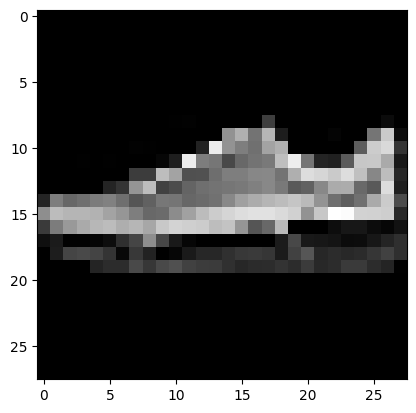

In [23]:
plt.imshow(x.squeeze().cpu(), cmap="gray")
plt.show()